In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

from runners.vStirap3lvlRunner import ExperimentalRunner, Atom, Cavity, LaserCoupling, CavityCoupling

### Single 3-level system simulation

Here we will just demo how to set up, run and analyse a single three-level system using the [vStirap3lvlRunner](runners.vStirap3lvlRunner).

In [2]:
'''
Set up system
'''

'''
class Atom(RunnerDataClass):
    atom_states: dict = field(default_factory=dict)
    M: int = 4
    gamma: float = 3 * 2. * np.pi
    branching_ratios: list = field(default_factory=list)
    R_AL: np.matrix = np.sqrt(1 / 2) * np.matrix([[1, i],
                                                  [i, 1]])
'''
gamma=3 * 2. * np.pi
branching_ratios = [0,0,1]

atom=Atom(gamma=gamma,
          branching_ratios=branching_ratios)

'''
class Cavity(RunnerDataClass):
    N: int = 2
    cavity_states: list = field(default_factory=list)
    g: float = 3 * 2. * np.pi
    kappa1: float = 3 * 2. * np.pi
    kappa2: float = 3 * 2. * np.pi
    deltaP: float = 0 * 2. * np.pi
    R_CL: np.matrix = np.matrix([[1, 0],
                                 [0, 1]])
    R_ML: np.matrix = np.sqrt(1 / 2) * np.matrix([[1, i],
                                                  [i, 1]])
'''
g0=24 * (2*np.pi)
kappa1,kappa2 = 19 * 2.*np.pi, 0.9 * 2.*np.pi
deltaP = 20 * 2.*np.pi

cavity=Cavity(g=g0,
              kappa1=kappa1,
              kappa2=kappa2,
              deltaP=deltaP)

'''
class LaserCoupling(RunnerDataClass):
    omega0: float
    g: str
    x: str
    deltaL: float
    args_ham: dict
    pulse_shape: str = 'np.piecewise(t, [t<length_pulse], [np.sin((np.pi/length_pulse)*t)**2,0])'
'''
deltaL=0
length_pulse = 1
omega0=20 * 2 * np.pi

laser_couplings = []

for g_state, x_state, delta, _ in Atom.get_couplings_sigma_plus(deltaL):
    laser_couplings.append(LaserCoupling(omega0=omega0,
                                         g=g_state,
                                         x=x_state,
                                         deltaL=delta,
                                         args_ham={"length_pulse":length_pulse}))
    
'''
class CavityCoupling(RunnerDataClass):
    g0: float
    g: str
    x: str
    deltaC: float
    deltaM: int
'''
deltaC=0
cavity_couplings = []

for g_state, x_state, delta, deltaM in Atom.get_couplings_sigma_minus(deltaC):
    cavity_couplings.append(CavityCoupling(g0=cavity.g,
                                           g=g_state,
                                           x=x_state,
                                           deltaC=delta,
                                           deltaM=deltaM))

In [3]:
runner = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=False)

In [4]:
t_length=1.2
n_steps=201
psi0=['gM',0,0]

results = runner.run(psi0=psi0)

In [5]:
def plot_results(results):
    exp_anX, exp_anY = results.get_cavity_number(cavity.R_CL)
    exp_emX, exp_emY = results.get_cavity_emission(cavity.R_CL)
    exp_anP, exp_anM = results.get_cavity_number(atom.R_AL)
    exp_emP, exp_emM = results.get_cavity_emission(atom.R_AL)
    
    exp_sp = results.get_total_spontaneous_emission()
    
    exp_atM, exp_atX, exp_atP, exp_atD = results.get_atomic_population(['gM', 'x0', 'gP', 'd'])
    
    t = results.output.times
    tStep = np.mean(np.ediff1d(t))
    
    n_X = np.trapz(exp_emX, dx=tStep)
    n_Y = np.trapz(exp_emY, dx=tStep)
    n_ph = n_X+n_Y
    n_sp = np.trapz(exp_sp, dx=tStep)
    
    plt.rcParams['text.usetex'] = True
    
    print('Photon emission:', np.round(n_ph,3))
    print('Photon emission in |X>, |Y>:', np.round(n_X,3), np.round(n_Y,3))
    print('Spontaneous emission:', np.round(n_sp,3))
    
    # Plot the results
    f1, ((a1a, a1b),
         (a2a, a2b)) = plt.subplots(2, 2, sharex=True, figsize=(12, 11./2))
    
    a1a.set_title('\\textbf{Cavity mode population}', fontsize=16)
    a1b.set_title('\\textbf{Cavity emission rate} ($1/\mu s$)', fontsize=16, fontweight='bold')
    
    ###
    axA,axB = a1a,a1b
    
    axA.plot(t, exp_anP, 'b', label='$+ (\sigma^{+})$')
    axA.plot(t, exp_anM, 'g', label='$- (\sigma^{-})$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emP, 'b', label='$+ (\sigma^{+})$')
    axB.plot(t, exp_emM, 'g', label='$- (\sigma^{-})$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    ###
    axA,axB = a2a,a2b
    
    axA.plot(t, exp_anX, 'b', label='$X$')
    axA.plot(t, exp_anY, 'g', label='$Y$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emX, 'b', label='$X$')
    axB.plot(t, exp_emY, 'g', label='$Y$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    f2, (a) = plt.subplots(1, 1, sharex=True, figsize=(12, 11/4))

    a.set_title('\\textbf{Atomic state}', fontsize=16)
    
    a.plot(t, exp_atM, 'b', label='$gM$')
    a.plot(t, exp_atP, 'g', label='$gP$')
    a.plot(t, exp_atX, '--r', label='$x0$')
    a.plot(t, exp_atD, '--y', label='$d$')
    
    a.set_xlabel('Time, $\mu s$')
    a.set_ylabel('Population')
    a.legend(loc=2)

Photon emission: 0.958
Photon emission in |X>, |Y>: 0.479 0.479
Spontaneous emission: 0.031


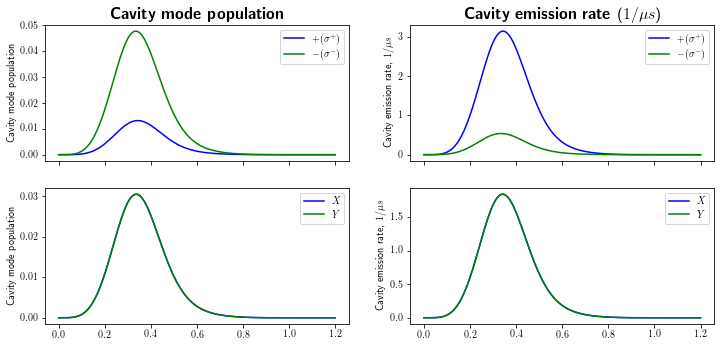

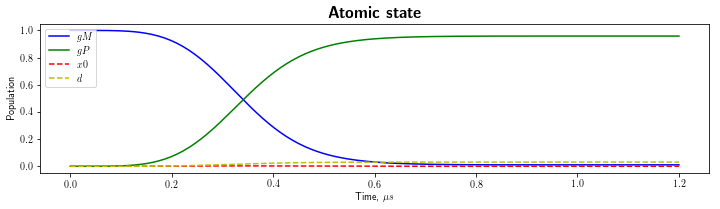

In [6]:
plot_results(results)

### Efficient running of multiple simulation and anaysis

It can be slow to compile the Hamiltonians used in these simulations, not to mention calculating the operators with which we analyse the result.  Fortunately we try to minimise the number of times these operations have to be performed.

For example, the Hamiltonian only needs to be re-compiled if a variable not passed in through the args dictionary changes.  So below, changing the birefringence requres re-compilation (boo) but laser power does not (yay).

Changing the birefringence also requires new _xxxOperators for the photon number and cavity emission operators, however once again the laser power does not.

So let's set up these cases and run them through (along with a direct copy of the above system reference).

In [7]:
runner2 = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

cavity3=Cavity(g=g0,
              kappa1=kappa1,
              kappa2=kappa2,
              deltaP=0*deltaP)

runner3 = ExperimentalRunner(atom=atom,
                            cavity=cavity3,
                            laser_couplings=laser_couplings,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

laser_couplings2 = []

for g_state, x_state, delta, _ in Atom.get_couplings_sigma_plus(deltaL):
    laser_couplings2.append(LaserCoupling(omega0=0.5*omega0,
                                         g=g_state,
                                         x=x_state,
                                         deltaL=delta,
                                         args_ham={"length_pulse":length_pulse}))

runner4 = ExperimentalRunner(atom=atom,
                            cavity=cavity,
                            laser_couplings=laser_couplings2,
                            cavity_couplings=cavity_couplings,
                            verbose=True)

Pre-compiled Hamiltonian, ExperimentalRunner_Hamiltonian_0.pyx, is suitable to run this experiment.


No suitable pre-compiled Hamiltonian found.  Generating Cython file...

done.
	New file is ExperimentalRunner_Hamiltonian_1.pyx.  Generated in 5.062 seconds.
Pre-compiled Hamiltonian, ExperimentalRunner_Hamiltonian_0.pyx, is suitable to run this experiment.


In [ ]:
results2 = runner2.run(psi0=psi0)
results3 = runner3.run(psi0=psi0)
results4 = runner4.run(psi0=psi0)

Photon emission: 0.964
Photon emission in |X>, |Y>: 0.485 0.479
Spontaneous emission: 0.031


Creating new number operator series.
Creating new number operator series.


Creating new number operator series.
Creating new number operator series.


Photon emission: 0.525
Photon emission in |X>, |Y>: 0.262 0.262
Spontaneous emission: 0.004


Photon emission: 0.731
Photon emission in |X>, |Y>: 0.367 0.364
Spontaneous emission: 0.024


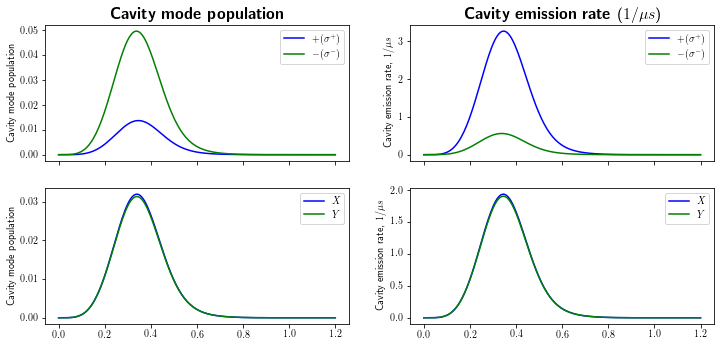

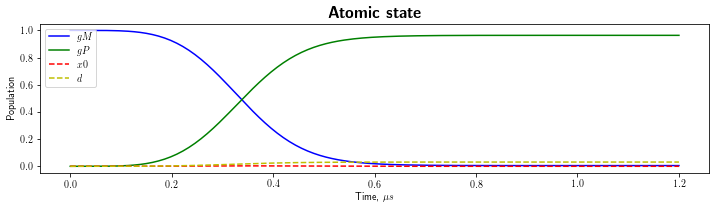

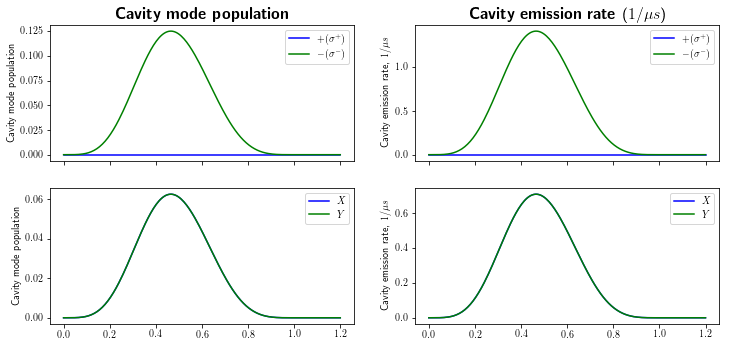

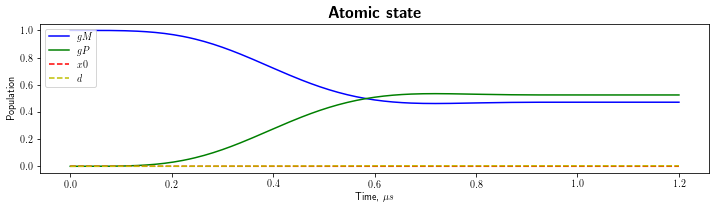

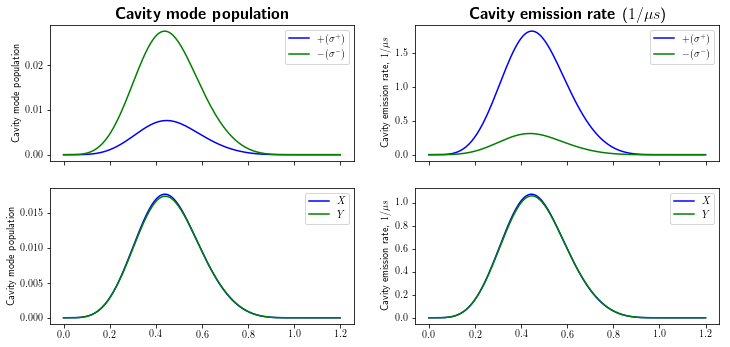

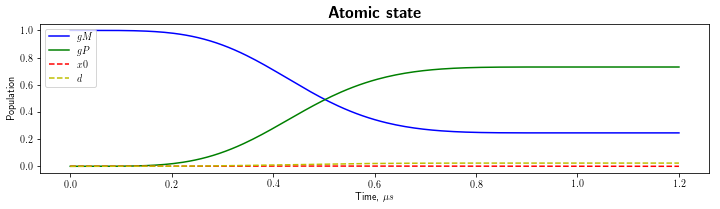

In [9]:
plot_results(results2)
plot_results(results3)
plot_results(results4)